Created: 4/3/24
Updated: 4/3/24
Author: Nicholas Ackerman
Purpose: Mix Rate BNC Retention analysis that utilzies combinations and timeframes to produce detailed chart of the most and least impactful segments on 30 and 60 day retention rates. The idea of this program will be to have the user submit multiple imputs
[timeframe, segmentation level, segments, etc] and have the mix rate calcualtion be completed at the level intentended. The program reaches out to Snowflake to pull in raw data from the ESA_MIX_RATE_SEGMENTATION table. 

In [2]:
#import libraries
#created: Nicholas Ackerman
#Date: 4/9/2024
#Version 2
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from datetime import datetime, timezone, timedelta
from itertools import combinations
from itertools import permutations
import datetime as dt
import random
import pandas as pd
import numpy as np
from snowflake.connector.pandas_tools import pd_writer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#Link to Documentation

In [3]:
#Connection setup and functions
class SFConnection:
    def __init__(self):
        self.name = ''
        self.connection = ''
        self.engine = ''

    def open_conn(self):
        username = self.name + '@safeway.com'
        account_identifier = 'abs_itds_prd.west-us-2.privatelink'

        # Create an engine to connect to Snowflake
        self.engine = create_engine(
        f'snowflake://{username}@{account_identifier}/?authenticator=externalbrowser'
        )
        self.connection = self.engine.connect()
        print("Connection Opened")

    def test_conn(self):
        try:
            self.open_conn()
            results = self.connection.execute('select current_version()').fetchone()
            print("Snowflake connected to Version: {}".format(results[0]))
            return("CONNECTED")
        except Exception as e:
            print("Snowflake connection Error")
            return("ERR")

    def run_query(self, sql):
        self.connection.execute("BEGIN")
        self.connection.execute(sql)
        self.connection.execute("COMMIT")

    def query_to_df(self, sql):
        results = self.connection.execute(sql).fetchall()
        columns = results[0].keys()
        return pd.DataFrame(results, columns=columns)
        
    def close_conn(self):
        self.connection.close()
        self.engine.dispose()
        print("Connection Closed")

    def add_name(self, name):
        self.name = name
    
    #accepts a dataframe and a table name in lowercase. It is fixed currently to the FBI Schema. You only need to pass through the tablename
    #The df must be in the exact format as table
    #This will upload in chuncks of 10,000 rows to Snowflake
    #This method will replace all current values from Dataframe 
    def load_dataframe_REPLACE(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='replace', index=False, chunksize=10000)
    
    #Method for inserting value without replacing to data tables 
    def load_dataframe_APPEND(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='append', index=False, chunksize=10000)

In [4]:
#--Query needed for Proactive Communication to show the difference in 30 day retention before and after Proactive went live. Specifically in Jewel Osco
'''
Digitial Engagement Metrics: "EDM_BIZOPS_PRD"."FBI"."HB_ECOM_DATA_L12W_DE_METRICS"
'''

SQL_TIMEFRAME_INITAL = '''
select 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
--mrs.DIVISION,
mrs.URBANICITY,
CASE WHEN FRST_TXN_SAVE20_PROMO_CODE_FLAG > 0 or FRST_TXN_SAVE30_PROMO_CODE_FLAG > 0 OR CYBER_CODE > 0 THEN 'USED PROMO CODE' else 'DID NOT USE PROMO CODE' end as Promo_usage,
count(distinct household_id) as Total_Households,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) as Repeat_30_day,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_30_DAY,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) as Repeat_60_day,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_60_DAY
from "EDM_BIZOPS_PRD"."FBI"."ESA_MIX_RATE_SEGMENTATION" mrs
left join "EDM_BIZOPS_PRD"."FBI"."ESA_HOLISTIC_SCORECARD_TXN_CUSTOMER_SEGMENT" cs
on mrs.txn_id = cs.txn_id
WHERE 
cs.segment_1 IN ('BNC TO ACI', 'BNC TO ECOMM')
AND FISCAL_QUARTER_ID = '202302'
AND mrs.DIVISION = 'JEWEL OSCO'
group by 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
--mrs.DIVISION,
mrs.URBANICITY,
Promo_usage
'''

SQL_TIMEFRAME_FINAL = '''
select 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
--mrs.DIVISION,
mrs.URBANICITY,
CASE WHEN FRST_TXN_SAVE20_PROMO_CODE_FLAG > 0 or FRST_TXN_SAVE30_PROMO_CODE_FLAG > 0 OR CYBER_CODE > 0 THEN 'USED PROMO CODE' else 'DID NOT USE PROMO CODE' end as Promo_usage,
count(distinct household_id) as Total_Households,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) as Repeat_30_day,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_30_DAY,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) as Repeat_60_day,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_60_DAY
from "EDM_BIZOPS_PRD"."FBI"."ESA_MIX_RATE_SEGMENTATION" mrs
left join "EDM_BIZOPS_PRD"."FBI"."ESA_HOLISTIC_SCORECARD_TXN_CUSTOMER_SEGMENT" cs
on mrs.txn_id = cs.txn_id
WHERE 
cs.segment_1 IN ('BNC TO ACI', 'BNC TO ECOMM')
AND FISCAL_QUARTER_ID = '202304'
AND mrs.DIVISION = 'JEWEL OSCO'
group by 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
--mrs.DIVISION,
mrs.URBANICITY,
Promo_usage
'''

#Connection String Created and Query Pulled
conn = SFConnection()
conn.add_name('NACKE08') #Change to Current User LDAP
conn.test_conn()
dfTF1= conn.query_to_df(SQL_TIMEFRAME_INITAL)
dfTF2 = conn.query_to_df(SQL_TIMEFRAME_FINAL)
conn.close_conn()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Connection Opened
Snowflake connected to Version: 8.14.2
Connection Closed


In [ ]:
def MIX_RATE_FUNCTION(combination_columns):
    #COLUMN AGGREGATION
    #
    #///////////////////////////////////////////////////////////////////////
    # INITIAL TIME PERIOD
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp1 = pd.DataFrame()
    dfTemp1['TOTAL_HH'] = dfTF1.groupby(combination_columns)['total_households'].sum()
    dfTemp1['TOTAL_HH_PCT'] = dfTF1.groupby(combination_columns)['total_households'].sum() / dfTF1['total_households'].sum()
    dfTemp1['RPT_30_HH'] = dfTF1.groupby(combination_columns)['repeat_30_day'].sum()
    dfTemp1['RPT_RATE_30'] = dfTF1.groupby(combination_columns)['repeat_30_day'].sum() / dfTF1.groupby(combination_columns)['total_households'].sum()
    dfTemp1['RPT_60_HH'] = dfTF1.groupby(combination_columns)['repeat_60_day'].sum()
    dfTemp1['RPT_RATE_60'] = dfTF1.groupby(combination_columns)['repeat_60_day'].sum() / dfTF1.groupby(combination_columns)['total_households'].sum()
    #
    #///////////////////////////////////////////////////////////////////////
    # FINAL TIME PERIOD
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2 = pd.DataFrame()
    dfTemp2['TOTAL_HH'] = dfTF2.groupby(combination_columns)['total_households'].sum()
    dfTemp2['TOTAL_HH_PCT'] = dfTF2.groupby(combination_columns)['total_households'].sum() / dfTF2['total_households'].sum()
    dfTemp2['RPT_30_HH'] = dfTF2.groupby(combination_columns)['repeat_30_day'].sum()
    dfTemp2['RPT_RATE_30'] = dfTF2.groupby(combination_columns)['repeat_30_day'].sum() / dfTF2.groupby(combination_columns)['total_households'].sum()
    dfTemp2['RPT_60_HH'] = dfTF2.groupby(combination_columns)['repeat_60_day'].sum()
    dfTemp2['RPT_RATE_60'] = dfTF2.groupby(combination_columns)['repeat_60_day'].sum() / dfTF2.groupby(combination_columns)['total_households'].sum()
    #
    #///////////////////////////////////////////////////////////////////////
    # OVERALL GROUPS
    #///////////////////////////////////////////////////////////////////////
    #
    dfOverall = pd.DataFrame()
    dfOverall['INITIAL_TOTAL_HH'] = [dfTF1['total_households'].sum()]
    dfOverall['INITIAL_RPT_RATE_30'] = [dfTF1['repeat_30_day'].sum() / dfTF1['total_households'].sum()]
    dfOverall['INITIAL_RPT_RATE_60'] = [dfTF1['repeat_60_day'].sum() / dfTF1['total_households'].sum()]
    dfOverall['FINAL_TOTAL_HH'] = [dfTF2['total_households'].sum()]
    dfOverall['FINAL_RPT_RATE_30'] = [dfTF2['repeat_30_day'].sum() / dfTF2['total_households'].sum()]
    dfOverall['FINAL_RPT_RATE_60'] = [dfTF2['repeat_60_day'].sum() / dfTF2['total_households'].sum()]
    #Mix Rate Calcualtion 
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2['VARIANCE'] = dfTemp2['TOTAL_HH_PCT'] - dfTemp1['TOTAL_HH_PCT'] #Varience 
    dfTemp2['RPT_RATE_30_BPS_DIFF'] = (dfTemp2['RPT_RATE_30'] - dfTemp1['RPT_RATE_30'])*10000 #30 day repeat BPD Diff
    dfTemp2['30_DAY_RATE_CONTRIBUTION'] = dfTemp2['RPT_RATE_30_BPS_DIFF'] * dfTemp2['TOTAL_HH_PCT'] #30 day Rate Contribution
    dfTemp2['30_DAY_MIX_CONTRIBUTION'] = ((dfTemp1['RPT_RATE_30'] - dfOverall['INITIAL_RPT_RATE_30'][0]) * dfTemp2['VARIANCE'])*10000 #30 day Mix Contribution
    dfTemp2['TOTAL_CONTRIBUTION_30_DAYS'] = dfTemp2['30_DAY_RATE_CONTRIBUTION'] + dfTemp2['30_DAY_MIX_CONTRIBUTION']
    #
    #///////////////////////////////////////////////////////////////////////
    # 60 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2['RPT_RATE_60_BPS_DIFF'] = (dfTemp2['RPT_RATE_60'] - dfTemp1['RPT_RATE_60'])*10000 #60 day repeat BPD Diff
    dfTemp2['60_DAY_RATE_CONTRIBUTION'] = dfTemp2['RPT_RATE_60_BPS_DIFF'] * dfTemp2['TOTAL_HH_PCT'] #60 day Rate Contribution
    dfTemp2['60_DAY_MIX_CONTRIBUTION'] = ((dfTemp1['RPT_RATE_60'] - dfOverall['INITIAL_RPT_RATE_60'][0]) * dfTemp2['VARIANCE'])*10000 #60 day Mix Contribution
    dfTemp2['TOTAL_CONTRIBUTION_60_DAYS'] = dfTemp2['60_DAY_RATE_CONTRIBUTION'] + dfTemp2['60_DAY_MIX_CONTRIBUTION']
    dfTemp2
    #Mix Rate Calcualtion return values
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfFINAL = pd.DataFrame()
    dfFINAL['TOTAL_CONTRIBUTION_30_DAYS'] = dfTemp2['TOTAL_CONTRIBUTION_30_DAYS']
    dfFINAL['TOTAL_CONTRIBUTION_60_DAYS'] = dfTemp2['TOTAL_CONTRIBUTION_60_DAYS']
    dfFINAL['FEATURES'] = '::'.join(combination_columns)
    dfFINAL['NUM_FEATURES'] = len(combination_columns)
    dfFINAL['NUM_HH_FIRST_TIMEPERIOD'] = dfTemp1['TOTAL_HH']
    dfFINAL['NUM_HH_LAST_TIMEPERIOD'] = dfTemp2['TOTAL_HH']
    dfFINAL['VARIANCE'] = dfTemp2['VARIANCE']
    dfFINAL['RPT_RATE_60_BPS_DIFF'] = dfTemp2['RPT_RATE_60_BPS_DIFF']
    dfFINAL['60_DAY_RATE_CONTRIBUTION'] = dfTemp2['60_DAY_RATE_CONTRIBUTION']
    dfFINAL['60_DAY_MIX_CONTRIBUTION'] = dfTemp2['60_DAY_MIX_CONTRIBUTION']
    dfFINAL['INDEX'] = dfFINAL.index
    #INSERT COLUMNS INTO DATAFRAME
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    i = 1
    for item in combination_columns:
        dfFINAL['COLUMN_'+str(i)] = item
        i+=1

    return dfFINAL.reset_index(drop=True)

In [ ]:
#COMBINATION_SEGMENTS = ['previous_store_sales_category', 'delivery_type','svclvl_type','division', 'urbanicity']
COMBINATION_SEGMENTS = list(dfTF1.iloc[:,1:-5].columns)

In [ ]:
dfFINALOUTPUT = pd.DataFrame()
# This section is used for the individual tabs for the scores
for item in COMBINATION_SEGMENTS:
    dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,MIX_RATE_FUNCTION([item])], ignore_index=True)

#Columns from INDEXES
dfFINALOUTPUT['INDEX_1'] = dfFINALOUTPUT['INDEX']
dfFINALOUTPUT['INDEX_2'] = dfFINALOUTPUT['INDEX']
#dfFINALOUTPUT['INDEX_3'] = dfFINALOUTPUT['INDEX']
dfFINALOUTPUT

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,INDEX_1,INDEX_2
0,19.246169,56.356073,previous_store_sales_category,1,14556.0,19425,-0.089580,84.978159,31.509138,24.846934,A - NO_STORE_TXNS,previous_store_sales_category,A - NO_STORE_TXNS,A - NO_STORE_TXNS
1,-76.051448,-23.505598,previous_store_sales_category,1,6973.0,12625,0.020451,-76.725929,-18.490205,-5.015393,B - 1-250,previous_store_sales_category,B - 1-250,B - 1-250
2,-64.535769,-15.601783,previous_store_sales_category,1,3398.0,6641,0.019295,-164.774464,-20.887746,5.285962,C - 250-500,previous_store_sales_category,C - 250-500,C - 250-500
3,-83.665160,-1.546401,previous_store_sales_category,1,3405.0,7050,0.026881,-133.858219,-18.013676,16.467274,D - 500-1000,previous_store_sales_category,D - 500-1000,D - 500-1000
4,-24.265011,14.291039,previous_store_sales_category,1,1543.0,3206,0.012396,104.575470,6.399728,7.891311,E - 1000-1500,previous_store_sales_category,E - 1000-1500,E - 1000-1500
5,-24.178781,-0.775802,previous_store_sales_category,1,1472.0,2890,0.008610,-173.706183,-9.582555,8.806752,F - 1500-3000,previous_store_sales_category,F - 1500-3000,F - 1500-3000
6,-9.021346,-1.355637,previous_store_sales_category,1,271.0,546,0.001851,-289.120474,-3.013281,1.657644,G - 3000-15000,previous_store_sales_category,G - 3000-15000,G - 3000-15000
7,NaN,NaN,previous_store_sales_category,1,NaN,5,NaN,NaN,NaN,NaN,H - 15000 +,previous_store_sales_category,H - 15000 +,H - 15000 +
8,-90.592087,-72.982099,delivery_type,1,8446.0,13066,-0.017718,-215.893669,-53.845665,-19.136434,DELIVERY,delivery_type,DELIVERY,DELIVERY
9,-171.775293,100.885078,delivery_type,1,23172.0,39322,0.017718,143.700153,107.860148,-6.975070,DUG,delivery_type,DUG,DUG


In [ ]:
# This section is used for the combination groupings tabs for the scores
PERMS = 2
#comb = combinations(COMBINATION_SEGMENTS, COMBINATIONS)
perm = permutations(COMBINATION_SEGMENTS, PERMS)
permLists = []
for segment in perm:
    temp = []
    for category in segment:
        temp.append(category)
    permLists.append(temp)
    
# This section is used for the individual tabs for the scores
for item in permLists:
    dfTemp = MIX_RATE_FUNCTION(item)
    tuple_list = dfTemp['INDEX'].tolist()
    dfTemp[['INDEX_1', 'INDEX_2']] = pd.DataFrame(tuple_list, index=dfTemp.index)
    dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,dfTemp], ignore_index=True)

In [ ]:
# # This section is used for the combination groupings tabs for the scores
# PERMS = 3
# #comb = combinations(COMBINATION_SEGMENTS, COMBINATIONS)
# perm = permutations(COMBINATION_SEGMENTS, PERMS)
# permLists = []
# for segment in perm:
#     temp = []
#     for category in segment:
#         temp.append(category)
#     permLists.append(temp)

# # This section is used for the individual tabs for the scores
# for item in permLists:
#     #dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,MIX_RATE_FUNCTION(item)], ignore_index=True) #ORIGINAL 
#     dfTemp = MIX_RATE_FUNCTION(item)
#     tuple_list = dfTemp['INDEX'].tolist()
#     dfTemp[['INDEX_1', 'INDEX_2', 'INDEX_3']] = pd.DataFrame(tuple_list, index=dfTemp.index)
#     dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,dfTemp], ignore_index=True)

In [ ]:
#if Null value is found then use the 
dfFINALOUTPUT.loc[~dfFINALOUTPUT['COLUMN_1'].isnull() & dfFINALOUTPUT['COLUMN_2'].isnull(), 'COLUMN_2'] = dfFINALOUTPUT['COLUMN_1']
#dfFINALOUTPUT.loc[~dfFINALOUTPUT['COLUMN_1'].isnull() & ~dfFINALOUTPUT['COLUMN_2'].isnull() & dfFINALOUTPUT['COLUMN_3'].isnull(), 'COLUMN_3'] = dfFINALOUTPUT['COLUMN_1'] + str("::") + dfFINALOUTPUT['COLUMN_2']
dfFINALOUTPUT = dfFINALOUTPUT.sort_values(by = 'TOTAL_CONTRIBUTION_60_DAYS', ascending = False)
dfFINALOUTPUT

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,INDEX_1,INDEX_2,COLUMN_2
17,60.324026,138.543345,promo_usage,1,6602.0,12118,0.022507,699.397708,161.779442,-23.236098,USED PROMO CODE,promo_usage,USED PROMO CODE,USED PROMO CODE,promo_usage
125,61.075859,135.711956,delivery_type::promo_usage,2,5739.0,10115,0.011568,778.210192,150.255709,-14.543753,"(DUG, USED PROMO CODE)",delivery_type,DUG,USED PROMO CODE,promo_usage
231,61.075859,135.711956,promo_usage::delivery_type,2,5739.0,10115,0.011568,778.210192,150.255709,-14.543753,"(USED PROMO CODE, DUG)",promo_usage,USED PROMO CODE,DUG,delivery_type
80,80.714148,107.577727,previous_store_sales_category::promo_usage,2,3574.0,4672,-0.023856,747.675372,66.678234,40.899492,"(A - NO_STORE_TXNS, USED PROMO CODE)",previous_store_sales_category,A - NO_STORE_TXNS,USED PROMO CODE,promo_usage
221,80.714148,107.577727,promo_usage::previous_store_sales_category,2,3574.0,4672,-0.023856,747.675372,66.678234,40.899492,"(USED PROMO CODE, A - NO_STORE_TXNS)",promo_usage,USED PROMO CODE,A - NO_STORE_TXNS,previous_store_sales_category
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,NaN,NaN,delivery_type::previous_store_sales_category,2,NaN,4,NaN,NaN,NaN,NaN,"(DUG, H - 15000 +)",delivery_type,DUG,H - 15000 +,previous_store_sales_category
133,NaN,NaN,svclvl_type::previous_store_sales_category,2,NaN,2,NaN,NaN,NaN,NaN,"(EXPRESS, H - 15000 +)",svclvl_type,EXPRESS,H - 15000 +,previous_store_sales_category
148,NaN,NaN,svclvl_type::previous_store_sales_category,2,NaN,3,NaN,NaN,NaN,NaN,"(STANDARD, H - 15000 +)",svclvl_type,STANDARD,H - 15000 +,previous_store_sales_category
191,NaN,NaN,urbanicity::previous_store_sales_category,2,NaN,5,NaN,NaN,NaN,NaN,"(Urban, H - 15000 +)",urbanicity,Urban,H - 15000 +,previous_store_sales_category


In [ ]:
#Export of Dataframne
dfFINALOUTPUT.to_excel('PY_OUTPUT_EXPORT_COMBINATIONS_PROMO_CODES.xlsx')

<Figure size 800x600 with 0 Axes>

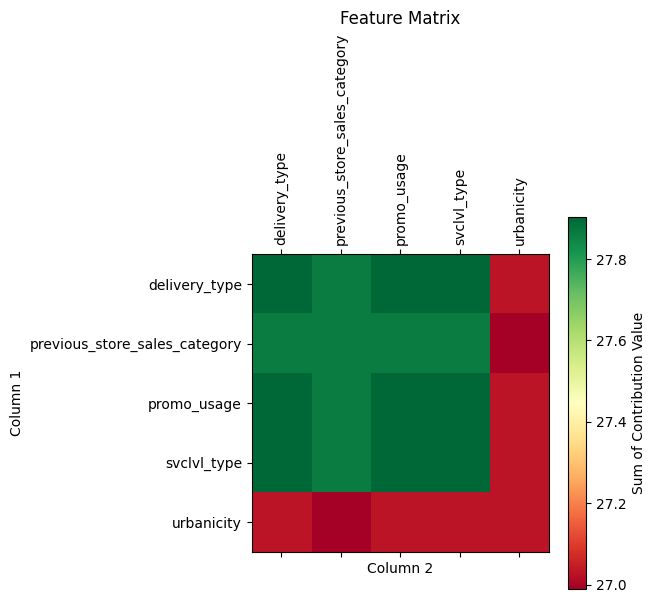

In [ ]:
#Future section to build charts and tables
#
#///////////////////////////////////////////////////////////////////////
# CHARTS and TABLES
#///////////////////////////////////////////////////////////////////////
#IN PROGRESS 
dfGraphs = pd.DataFrame()
dfGraphs = dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum().unstack(fill_value=0)

  
plt.figure(figsize=(8, 6))
plt.matshow(dfGraphs, cmap='RdYlGn')  # You can choose a different colormap if desired
plt.xticks(range(len(dfGraphs.columns)), dfGraphs.columns, rotation=90)
plt.yticks(range(len(dfGraphs.index)), dfGraphs.index)
plt.xlabel('Column 2')
plt.ylabel('Column 1')
plt.title('Feature Matrix')
plt.colorbar(label='Sum of Contribution Value')
plt.show()



INDEX_2                                               A - NO_STORE_TXNS  \
COLUMN_1                      INDEX_1                                     
delivery_type                 DELIVERY                       -42.658633   
                              DUG                             99.014706   
previous_store_sales_category A - NO_STORE_TXNS               56.356073   
                              B - 1-250                        0.000000   
                              C - 250-500                      0.000000   
                              D - 500-1000                     0.000000   
                              E - 1000-1500                    0.000000   
                              F - 1500-3000                    0.000000   
                              G - 3000-15000                   0.000000   
                              H - 15000 +                      0.000000   
promo_usage                   DID NOT USE PROMO CODE         -51.221654   
                              USED PROMO CODE                107.577727   
svclvl_type                   EXPRESS                         17.654991   
                              FLASH                            2.475618   
                              STANDARD                        36.225464   
urbanicity                    Rural                           -0.009773   
                              Suburban                        59.427388   
                              Urban                           -5.193187   

INDEX_2                                               B - 1-250  C - 250-500  \
COLUMN_1                      INDEX_1                                          
delivery_type                 DELIVERY               -20.340582   -10.609829   
                              DUG                     -3.165015    -4.991954   
previous_store_sales_category A - NO_STORE_TXNS        0.000000     0.000000   
                              B - 1-250              -23.505598     0.000000   
                              C - 250-500              0.000000   -15.601783   
                              D - 500-1000             0.000000     0.000000   
                              E - 1000-1500            0.000000     0.000000   
                              F - 1500-3000            0.000000     0.000000   
                              G - 3000-15000           0.000000     0.000000   
                              H - 15000 +              0.000000     0.000000   
promo_usage                   DID NOT USE PROMO CODE -24.270158   -19.252702   
                              USED PROMO CODE          0.764560     3.650919   
svclvl_type                   EXPRESS                -21.399780   -18.810682   
                              FLASH                    8.272416     0.110196   
                              STANDARD               -10.378233     3.098703   
urbanicity                    Rural                   -3.520669    -4.947740   
                              Suburban                -7.516585   -11.255218   
                              Urban                  -11.445232     0.539552   

INDEX_2                                               D - 500-1000   DELIVERY  \
COLUMN_1                      INDEX_1                                           
delivery_type                 DELIVERY                   -3.576165 -72.982099   
                              DUG                         2.029764   0.000000   
previous_store_sales_category A - NO_STORE_TXNS           0.000000 -42.658633   
                              B - 1-250                   0.000000 -20.340582   
                              C - 250-500                 0.000000 -10.609829   
                              D - 500-1000               -1.546401  -3.576165   
                              E - 1000-1500               0.000000   6.564350   
                              F - 1500-3000               0.000000  -3.346896   
                              G - 3000-15000              0.000000   1.053793   
       

<Figure size 600x600 with 0 Axes>

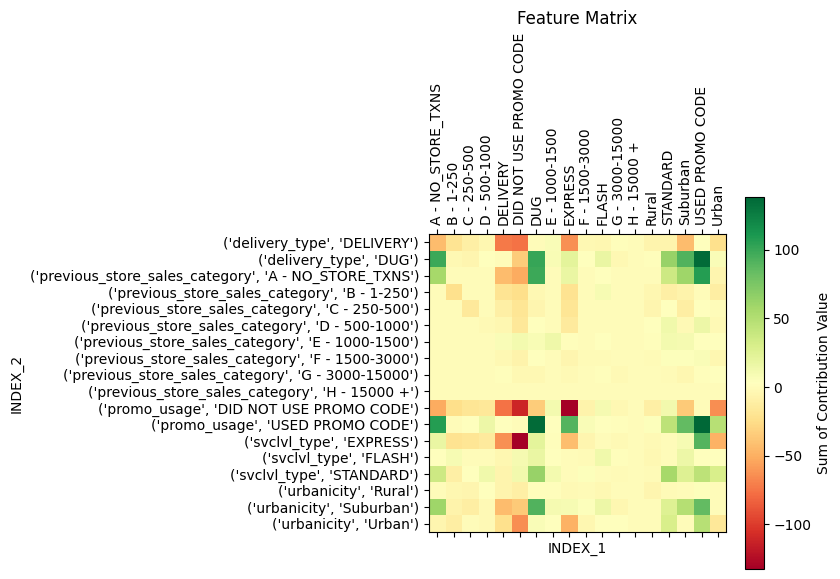

In [ ]:
#Future section to build charts and tables
#
#///////////////////////////////////////////////////////////////////////
# CHARTS and TABLES
#///////////////////////////////////////////////////////////////////////
#
dfGraph_Lvl_2 = pd.DataFrame()
dfGraph_Lvl_2 = dfFINALOUTPUT.groupby(['COLUMN_1','INDEX_1', 'INDEX_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum().unstack(fill_value=0)
display(dfGraph_Lvl_2)
# plt.imshow(dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum(), cmap ="RdYlBu") 
  
plt.figure(figsize=(5, 5), dpi=120)
plt.matshow(dfGraph_Lvl_2, cmap='RdYlGn')  # You can choose a different colormap if desired
plt.xticks(range(len(dfGraph_Lvl_2.columns)), dfGraph_Lvl_2.columns, rotation=90)
plt.yticks(range(len(dfGraph_Lvl_2.index)), dfGraph_Lvl_2.index)
plt.xlabel('INDEX_1')
plt.ylabel('INDEX_2')
plt.title('Feature Matrix')
plt.colorbar(label='Sum of Contribution Value')
plt.show()


In [ ]:
dfFINALOUTPUT[(dfFINALOUTPUT['COLUMN_1'] == 'division') & (dfFINALOUTPUT['COLUMN_2'] != 'division')]

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,INDEX_1,INDEX_2,COLUMN_2
411,12.197114,12.329721,division::delivery_type,2,43802.0,43490,0.000284,402.703100,12.179693,0.150029,"(JEWEL OSCO, DELIVERY)",division,JEWEL OSCO,DELIVERY,delivery_type
415,10.176079,12.147591,division::delivery_type,2,83948.0,66241,-0.011354,335.804129,15.469450,-3.321858,"(NORCAL, DELIVERY)",division,NORCAL,DELIVERY,delivery_type
481,10.485870,11.630652,division::urbanicity,2,79097.0,74284,-0.002442,209.354187,10.815308,0.815344,"(NORCAL, Urban)",division,NORCAL,Urban,urbanicity
446,7.304850,10.256184,division::svclvl_type,2,151958.0,109678,-0.027665,62.026307,4.731049,5.525136,"(NORCAL, STANDARD)",division,NORCAL,STANDARD,svclvl_type
423,9.219569,10.127364,division::delivery_type,2,69629.0,56916,-0.008045,296.039676,11.717804,-1.590440,"(SOCAL, DELIVERY)",division,SOCAL,DELIVERY,delivery_type
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,-11.981353,-14.203580,division::urbanicity,2,104685.0,102718,-0.000171,-198.898538,-14.208234,0.004654,"(SOCAL, Suburban)",division,SOCAL,Suburban,urbanicity
412,-23.611387,-17.678711,division::delivery_type,2,98497.0,120264,0.016264,-179.077427,-14.977470,-2.701241,"(JEWEL OSCO, DUG)",division,JEWEL OSCO,DUG,delivery_type
424,-24.239369,-28.881003,division::delivery_type,2,155536.0,168543,0.010825,-217.929585,-25.543998,-3.337006,"(SOCAL, DUG)",division,SOCAL,DUG,delivery_type
433,NaN,NaN,division::svclvl_type,2,NaN,141,NaN,NaN,NaN,NaN,"(HAGGEN, FLASH)",division,HAGGEN,FLASH,svclvl_type


INDEX_2                 A - NO_STORE_TXNS  B - 1-250  C - 250-500  \
COLUMN_1 INDEX_1                                                    
division DENVER                 -0.969612  -1.162650     0.829378   
         HAGGEN                 -0.106629   0.077140     0.146639   
         INTERMOUNTAIN           1.703365   0.344801     0.620720   
         JEWEL OSCO             -4.242080  -4.675372    -0.564445   
         MID-ATLANTIC           -3.854819  -0.653131     0.523394   
         NORCAL                  5.601074   2.645339     1.934522   
         PORTLAND               -5.102246   0.747544     0.480405   
         SEATTLE                -3.302017  -1.929203     0.399876   
         SHAWS                  -1.514217  -1.295979    -0.335338   
         SOCAL                 -10.979178  -3.508601    -1.723985   
         SOUTHERN               -3.601122   1.213158     1.934476   
         SOUTHWEST              -6.527020  -0.325990    -0.583867   

INDEX_2                 D - 500-1000   DELIVERY        DUG  E - 1000-1500  \
COLUMN_1 INDEX_1                                                            
division DENVER            -0.173528   0.295798  -1.701606       0.372721   
         HAGGEN             0.071546   0.000000   0.014262      -0.030170   
         INTERMOUNTAIN      0.811640   0.315981   3.026173       0.123910   
         JEWEL OSCO         1.540302  12.329721 -17.678711       1.177444   
         MID-ATLANTIC      -0.024273   3.823446  -7.751776      -0.018499   
         NORCAL             3.309187  12.147591   1.687157       0.799571   
         PORTLAND           0.884645   1.444449  -4.590558       0.215333   
         SEATTLE           -1.900580   0.504484  -9.232570      -0.471650   
         SHAWS              0.146534   2.774114  -7.082558      -1.144346   
         SOCAL              0.140652  10.127364 -28.881003      -0.408933   
         SOUTHERN           0.681417   4.153013  -2.930709       0.780764   
         SOUTHWEST          1.366624   4.225941  -9.313953       0.865832   

INDEX_2                  EXPRESS  F - 1500-3000     FLASH  G - 3000-15000  \
COLUMN_1 INDEX_1                                                            
division DENVER        -0.700463      -0.145267 -0.636131       -0.148148   
         HAGGEN         0.053793      -0.125870  0.000000       -0.018393   
         INTERMOUNTAIN  2.122302      -0.425537  0.050459        0.159363   
         JEWEL OSCO     0.546453       1.622219  0.394892       -0.201763   
         MID-ATLANTIC  -0.705104       0.114591 -0.456510       -0.000001   
         NORCAL         4.082827      -0.196802 -0.504263       -0.279021   
         PORTLAND       2.335135      -0.154313  0.041319       -0.221371   
         SEATTLE       -1.674167      -0.894693  0.134338       -0.631703   
         SHAWS         -1.208714      -0.030033  2.223274       -0.143945   
         SOCAL         -7.501412      -1.592339  0.697509       -0.688587   
         SOUTHERN       1.115819       0.188596  0.520663        0.051214   
         SOUTHWEST     -1.020905       0.078028  0.000000        0.042769   

INDEX_2                 H - 15000 +     Rural   STANDARD   Suburban      Urban  
COLUMN_1 INDEX_1                                                                
division DENVER           -0.008701 -0.906846  -0.069213  -0.863599   0.408719  
         HAGGEN            0.000000  0.038760  -0.021731  -0.024498   0.000000  
         INTERMOUNTAIN     0.003893  1.557880   1.169394   1.248217  -0.051047  
         JEWEL OSCO       -0.005294 -0.425812  -6.290334 -11.329080   6.544110  
         MID-ATLANTIC     -0.015591  0.655461  -2.766715  -3.710134   0.185545  
         NORCAL            0.020878 -0.978474  10.256184   2.663707  11.630652  
         PORTLAND          0.003893 -1.497024  -5.522563  -2.646017  -0.340978  
         SEATTLE           0.001885 -1.269824  -7.188256  -7.666131   0.468177  
         SHAWS             0.008880 -2.130717  -5.323003  -2.9453

<Figure size 600x600 with 0 Axes>

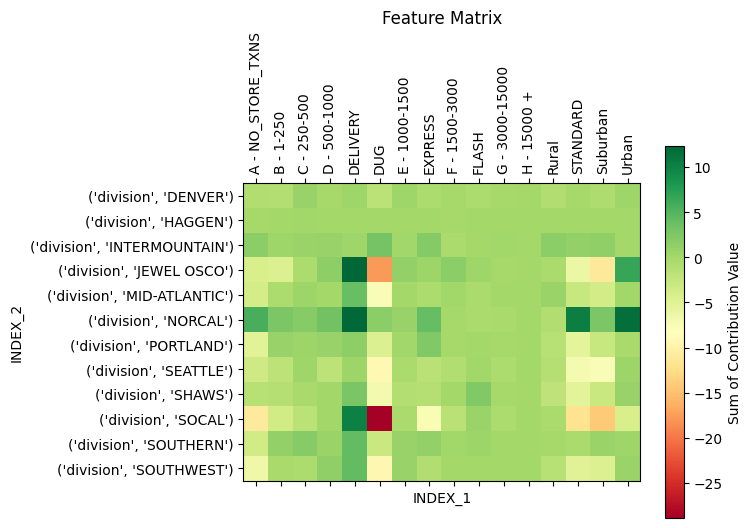

In [ ]:
#
#///////////////////////////////////////////////////////////////////////
# DIVISION LEVEL
#///////////////////////////////////////////////////////////////////////
#
dfGraph_Lvl_3 = pd.DataFrame()
dfDIVISION = dfFINALOUTPUT[(dfFINALOUTPUT['COLUMN_1'] == 'division') & (dfFINALOUTPUT['COLUMN_2'] != 'division')]
dfGraph_Lvl_3 = dfDIVISION.groupby(['COLUMN_1','INDEX_1', 'INDEX_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum().unstack(fill_value=0)
display(dfGraph_Lvl_3)
# plt.imshow(dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum(), cmap ="RdYlBu") 
  
plt.figure(figsize=(5, 5), dpi=120)
plt.matshow(dfGraph_Lvl_3, cmap='RdYlGn')  # You can choose a different colormap if desired
plt.xticks(range(len(dfGraph_Lvl_3.columns)), dfGraph_Lvl_3.columns, rotation=90)
plt.yticks(range(len(dfGraph_Lvl_3.index)), dfGraph_Lvl_3.index)
plt.xlabel('INDEX_1')
plt.ylabel('INDEX_2')
plt.title('Feature Matrix')
plt.colorbar(label='Sum of Contribution Value')
plt.show()
